In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import sys
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F

from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as fnn
from torchvision import transforms

root_path = './'
sys.path.append(root_path)

from hack_utils import Timer
from hack_utils import NUM_PTS
from hack_utils import ThousandLandmarksDataset, DebugThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

time: 864 ms


# Реализуем вспомогательные функции

Обучение модели

In [196]:
def train(model, loader, loss_fn, optimizer, device, epoch, writer, scheduler, bottom_k=12):
    model.train()
    train_loss = []
    train_mse_loss = []
    mse_loss_fn = nn.MSELoss()
    loss_id = []
    loader_len = len(loader)
    
    for n_batch, batch in tqdm(enumerate(loader), total=loader_len, desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        
        train_mse_loss.append(mse_loss_fn(pred_landmarks, landmarks).item())
        writer.add_scalar('train_batch_mse_loss', train_mse_loss[-1], epoch*loader_len + n_batch)
        
        losses = torch.mean(loss_fn(pred_landmarks, landmarks), dim=1)
        loss_id.extend([(loss.item(), i) for i, loss in enumerate(losses, n_batch*train_params['batch_size'])])
        loss_id = sorted(loss_id)[-bottom_k:]
        
        loss = torch.mean(losses)
        train_loss.append(loss.item())
        writer.add_scalar('train__batch_loss', train_loss[-1], epoch*loader_len + n_batch)
        
        scheduler.step(train_loss[-1])
        writer.add_scalar('lr_batch', optimizer.state_dict()['param_groups'][0]['lr'], epoch*loader_len + n_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    writer.add_figure('train_mse', np.mean(train_mse_loss), epoch)
    
    fig = worst_samples2figure(model, loader, device, loss_id_list=loss_id)
    writer.add_figure('train_worst_preds', fig, epoch)

    return np.mean(train_loss)

time: 15.6 ms


Валидация модели

In [197]:
def validate(model, loader, loss_fn, device, epoch, writer, bottom_k=12):
    model.eval()
    val_loss = []
    val_mse_loss = []
    mse_loss_fn = nn.MSELoss()
    loss_id = []
    loader_len = len(loader)
    
    for n_batch, batch in tqdm(enumerate(loader), total=loader_len, desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
            
        val_mse_loss.append(mse_loss_fn(pred_landmarks, landmarks).item())
        losses = torch.mean(loss_fn(pred_landmarks, landmarks), dim=1)
        loss_id.extend([(loss.item(), i) for i, loss in enumerate(losses, n_batch*train_params['batch_size'])])
        loss_id = sorted(loss_id)[-bottom_k:]
        
        loss = torch.mean(losses)
        val_loss.append(loss.item())
    
    writer.add_figure('val_mse', np.mean(val_mse_loss), epoch)
    
    fig = worst_samples2figure(model, loader, device, loss_id_list=loss_id)
    writer.add_figure('val_worst_preds', fig, epoch)

    return np.mean(val_loss)

time: 12.4 ms


Предсказание моделью

def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

Создание названия эксперимента

In [5]:
def get_exp_name(train_params: dict, name: str = None) -> str:
    cur_time = time.strftime("%b_%d_%Y_%H:%M:%S", time.localtime())
    exp_name = f"{cur_time}__"
    if name is not None:
        exp_name += f"{name}_"
    exp_name += f"model={train_params['base_model']}_bs={train_params['batch_size']}_"\
        f"epochs={train_params['epochs']}_lr={train_params['lr']}_"\
        f"lr_decay={train_params['lr_decay']}_w_decay={train_params['weight_decay']}"
    return exp_name

time: 11.1 ms


Отрисовка предсказаний

In [15]:
from typing import List, Dict, Any, Tuple

mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)


def tensor_image2numpy(image: torch.Tensor) -> np.ndarray:
    # revert normalization
    image = (image * std) + mean
    
    return np.array(F.to_pil_image(image))


def draw_landmarks(image: np.ndarray, landmarks: np.ndarray) -> np.ndarray:
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)

    return image


def figure_landmark_examples(images: torch.Tensor, landmarks: torch.Tensor, landmarks2=None, titles=None):
    n_images = images.shape[0]
    if landmarks2 is not None:
        n_images *= 2
        
    n_cols = 4
    n_rows = n_images // n_cols + int(n_images % n_cols != 0)

    fig = plt.figure(figsize=(25, n_rows * 8))
    j = 1
    for i, (image, landmark) in enumerate(zip(images, landmarks)):
        image = tensor_image2numpy(image)
        landmark = np.array(landmark.reshape(NUM_PTS, 2))
        
        new_image = draw_landmarks(image.copy(), landmark)

        ax = fig.add_subplot(n_rows, n_cols, j)
        ax.imshow(new_image)
        if titles is not None:
            ax.set_title(titles[i])
        j += 1
        
        if landmarks2 is not None:
            landmark = np.array(landmarks2[i].reshape(NUM_PTS, 2))
            new_image = draw_landmarks(image, landmark)

            ax = fig.add_subplot(n_rows, n_cols, j)
            ax.imshow(new_image)
            j += 1

    return fig


def figure_by_samples(samples: List[Dict[str, Any]]):
    n_images = len(samples)
    n_cols = 4
    n_rows = n_images // n_cols + int(n_images % n_cols != 0)

    fig = plt.figure(figsize=(25, n_rows * 8))
    for i, sample in enumerate(samples, 1):
        image = tensor_image2numpy(sample['image'])
        landmark = np.array(sample['landmarks']).reshape(NUM_PTS, 2)
        
        image = draw_landmarks(image, landmark)
        
        ax = fig.add_subplot(n_rows, n_cols, i)
        ax.imshow(image)
        if 'augmenter' in sample:
            ax.set_title(f"{sample['augmenter']}")

    return fig

time: 16.1 ms


In [7]:
def worst_samples2figure(model, loader, device, loss_id_list: List[Tuple[float, int]]):
    worst_idxs = list(map(lambda pair: pair[1], loss_id_list))
    
    worst_batch = loader.collate_fn([loader.dataset[idx] for idx in worst_idxs])
    images = worst_batch["image"].to(device)
    with torch.no_grad():
        pred_landmarks = model(images).cpu()
    
    if "augmenter" in worst_batch:
        augs = worst_batch["augmenter"]
        titles = [f"{augs[i]}, loss={loss_id_list[i][0]:.2f}" for i in range(len(loss_id_list))]
    else:
        titles = [f"loss={loss:.2f}" for loss, _ in loss_id_list]
        
    fig = figure_landmark_examples(images=images.to('cpu'), landmarks=pred_landmarks, titles=titles)
    
    return fig

time: 11.1 ms


# Основная часть

In [8]:
data_dir = os.path.join(root_path, 'data')
CROP_SIZE = 224  # размер изображений во время обучения сети - feature extractor'а на ImageNet
train_params = {'batch_size': 160}

time: 12.2 ms


### Настроим аугментацию

In [147]:
from augmentation import AffineAugmenter, CropAugmenter, BrightnessContrastAugmenter, BlurAugmenter, Augmenter
from augmentation import get_i_from_dict, batch2samples, RandomAugmentation, constant_augmenter

time: 165 ms


78it [00:00, 593.00it/s]


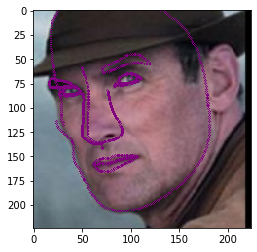

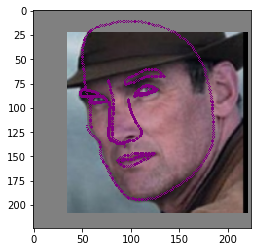

{'brightness': tensor(0., dtype=torch.float64),
 'contrast': tensor(0., dtype=torch.float64),
 'kernel': tensor(0),
 'scale': tensor(0.8337, dtype=torch.float64),
 'new_w': tensor(186),
 'new_h': tensor(186),
 'x_offset': tensor(35),
 'y_offset': tensor(23),
 'angle': tensor(0., dtype=torch.float64),
 'x_center': tensor(0),
 'y_center': tensor(0)}

time: 920 ms


In [11]:
with_inv=True

augmenter = RandomAugmentation(
    augmenters_list=[
        Augmenter(with_inv=with_inv),
        BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv),
        BlurAugmenter(max_kernel=5, with_inv=with_inv),
        CropAugmenter(min_scale=0.8, with_inv=with_inv),
        AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv),
    ],
    probs=[0.3, 0.2, 0.2, 0.15, 0.15],
#     probs=[0.5, 0.5],
    with_inv=with_inv,
)
# augmenter = BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv)

debug_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    augmenter,
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)), 
])

debug_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), debug_transforms)
debug_dataloader = data.DataLoader(
    debug_dataset, batch_size=100, num_workers=0, #num_workers=4, 
    pin_memory=True, shuffle=False, drop_last=False,
)

batch = next(iter(debug_dataloader))
images = batch["image"]#.to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
landmarks = batch["landmarks"]


i =  np.random.choice(images.shape[0])
# image = images[i].numpy()
image = tensor_image2numpy(images[i])
landmark = landmarks[i].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

sample = get_i_from_dict(i, batch)
sample['image'] = tensor_image2numpy(sample['image'])
inv_sample = augmenter.inv(sample)


image = inv_sample['image']
landmark = inv_sample['landmarks'].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

sample['params']

Посмотрим на пример батча с разными аугментациями

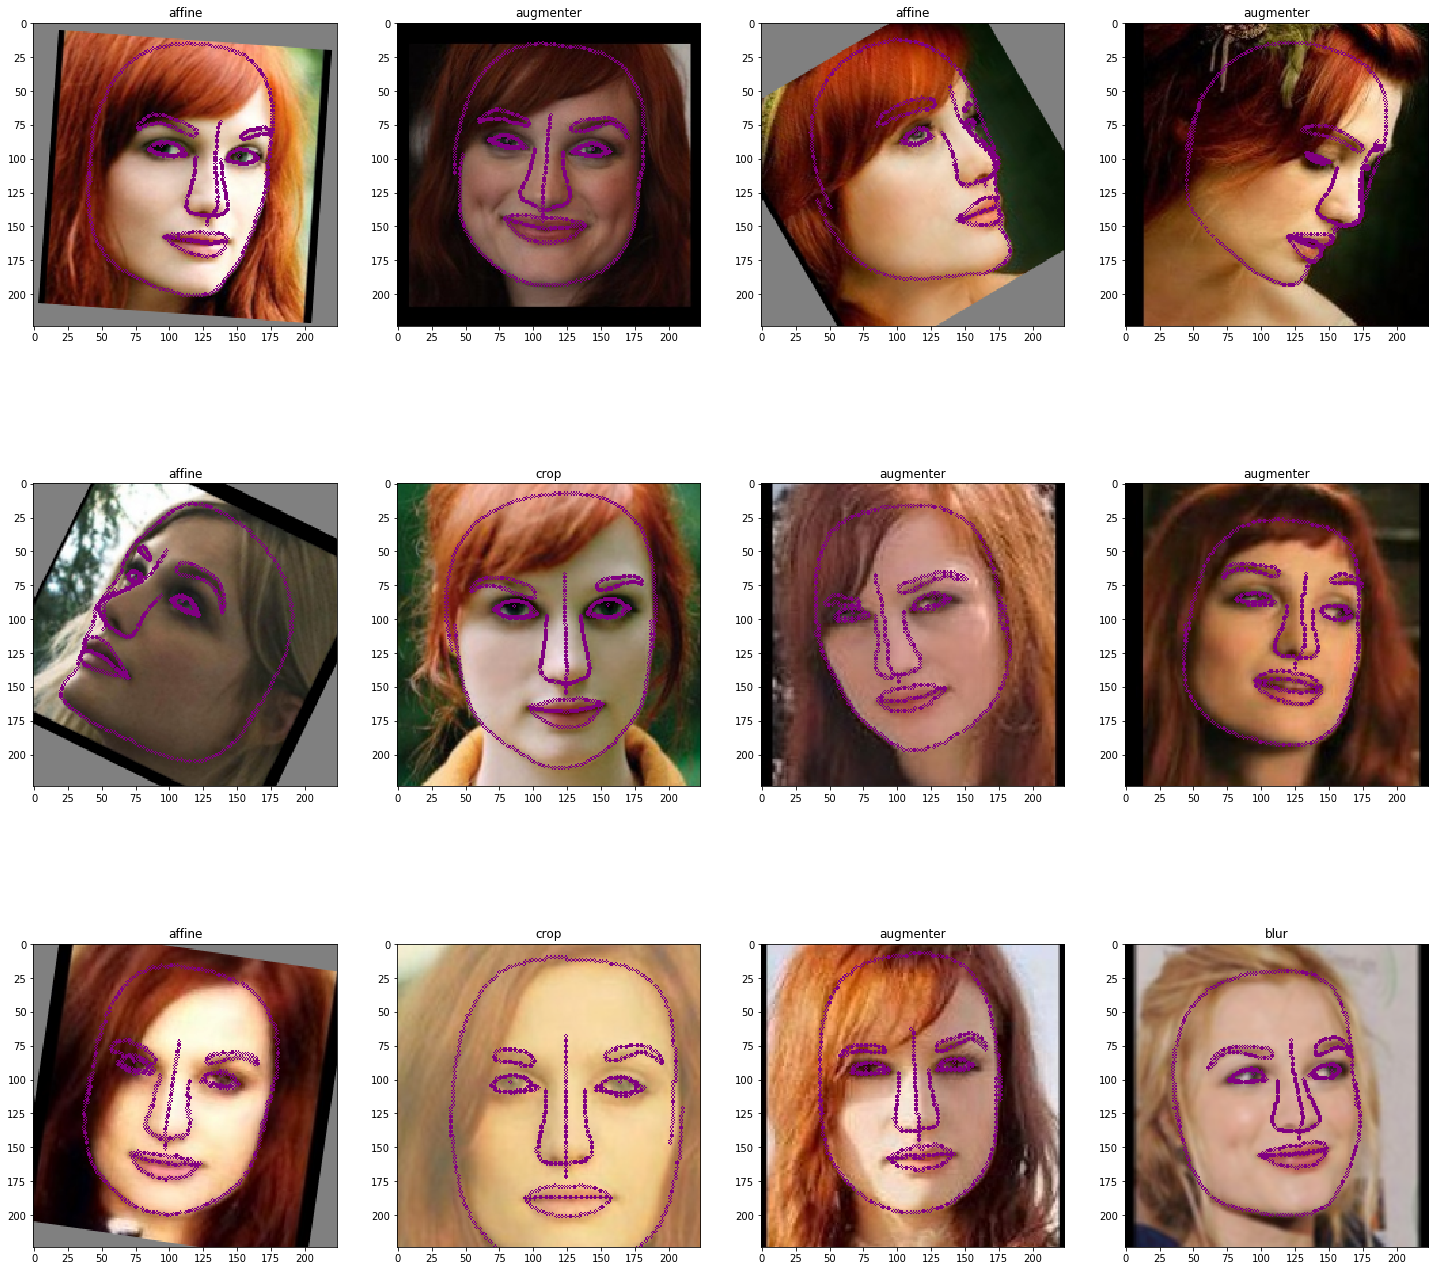

time: 1.98 s


In [12]:
figure_by_samples(list(batch2samples(batch, 12)))
plt.show()

In [13]:
del batch

time: 18.7 ms


### Подготовим данные для обучения

Пайплайн препроцессинга изображений

In [10]:
with_inv = False
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    RandomAugmentation(
        augmenters_list=[
            Augmenter(with_inv=with_inv),
            BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv),
            BlurAugmenter(max_kernel=5, with_inv=with_inv),
            CropAugmenter(min_scale=0.8, with_inv=with_inv),
            AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv),
        ],
        probs=[0.3, 0.2, 0.2, 0.15, 0.15],
        with_inv=with_inv,
    ),
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
])

with_inv = True
val_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    RandomAugmentation(
        augmenters_list=[
            Augmenter(with_inv=with_inv),
            BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv),
            BlurAugmenter(max_kernel=5, with_inv=with_inv),
            CropAugmenter(min_scale=0.8, with_inv=with_inv),
            AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv),
        ],
        probs=[0.3, 0.2, 0.2, 0.15, 0.15],
        with_inv=with_inv,
    ),
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
])

time: 13.4 ms


Загрузим данные для обучения и валидации

In [15]:
landmark_file_name = os.path.join(data_dir, 'train', 'landmarks.csv')
with open(landmark_file_name, "rt") as fp:
    num_lines = sum(1 for line in fp)

time: 1min 38s


In [18]:
num_lines, num_lines*0.2, num_lines*0.1, num_lines*0.05

(393931, 78786.20000000001, 39393.100000000006, 19696.550000000003)

time: 12.8 ms


In [11]:
train_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(
    train_dataset, batch_size=train_params['batch_size'], num_workers=4, 
    pin_memory=True, shuffle=True, drop_last=True,
)
val_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(
    val_dataset, batch_size=train_params['batch_size'], num_workers=4, 
    pin_memory=True, shuffle=False, drop_last=False,
)
# train_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), train_transforms)
# train_dataloader = data.DataLoader(
#     train_dataset, batch_size=10, num_workers=0, #num_workers=4, 
#     pin_memory=True, shuffle=True, drop_last=True,
# )
# val_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), val_transforms)
# val_dataloader = data.DataLoader(
#     val_dataset, batch_size=10, num_workers=0, #num_workers=4, 
#     pin_memory=True, shuffle=False, drop_last=False,
# )

374183it [14:00, 717.89it/s]
0it [00:00, ?it/s]
20004it [00:00, 200034.47it/s]
39882it [00:00, 199654.37it/s]
59757it [00:00, 199381.54it/s]
77945it [00:00, 193785.48it/s]
98620it [00:00, 197499.14it/s]
118925it [00:00, 199131.91it/s]
139557it [00:00, 201233.28it/s]
160393it [00:00, 203318.35it/s]
180601it [00:00, 202944.88it/s]
201225it [00:01, 203919.77it/s]
221767it [00:01, 204364.83it/s]
242631it [00:01, 205627.48it/s]
263204it [00:01, 205655.78it/s]
284105it [00:01, 206648.26it/s]
304977it [00:01, 207263.75it/s]
325872it [00:01, 207765.04it/s]
346586it [00:01, 207086.62it/s]
367251it [00:01, 206468.78it/s]
386201it [00:18, 3719.40it/s]  
386201it [00:18, 3719.40it/s]
386315it [00:18, 1637.48it/s]
386416it [00:18, 1182.00it/s]
386508it [00:19, 990.40it/s] 
386594it [00:19, 888.79it/s]
386676it [00:19, 822.60it/s]
386755it [00:19, 784.31it/s]
386831it [00:19, 763.34it/s]
386906it [00:19, 749.01it/s]
386980it [00:19, 735.59it/s]
387053it [00:19, 730.43it/s]
387126it [00:19, 718.50it/

time: 14min 49s


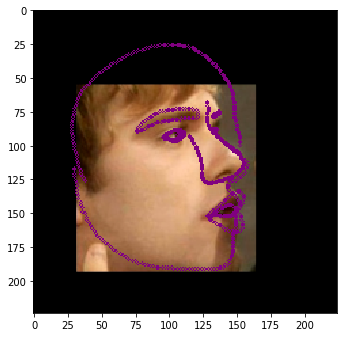

time: 8.93 s


In [12]:
batch = next(iter(val_dataloader))
images = batch["image"]#.to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
landmarks = batch["landmarks"]

n_images = 1
idxs = np.random.choice(images.shape[0], size=min(n_images, images.shape[0]), replace=False)
fig = figure_landmark_examples(images=images[idxs], landmarks=landmarks[idxs])
plt.show()

del batch
del images
del landmarks

## Эксперимент

Подберем параметры для lr scheduler и зададим параметры всего эксперимента

n_train_batches: 2338, patience: 584


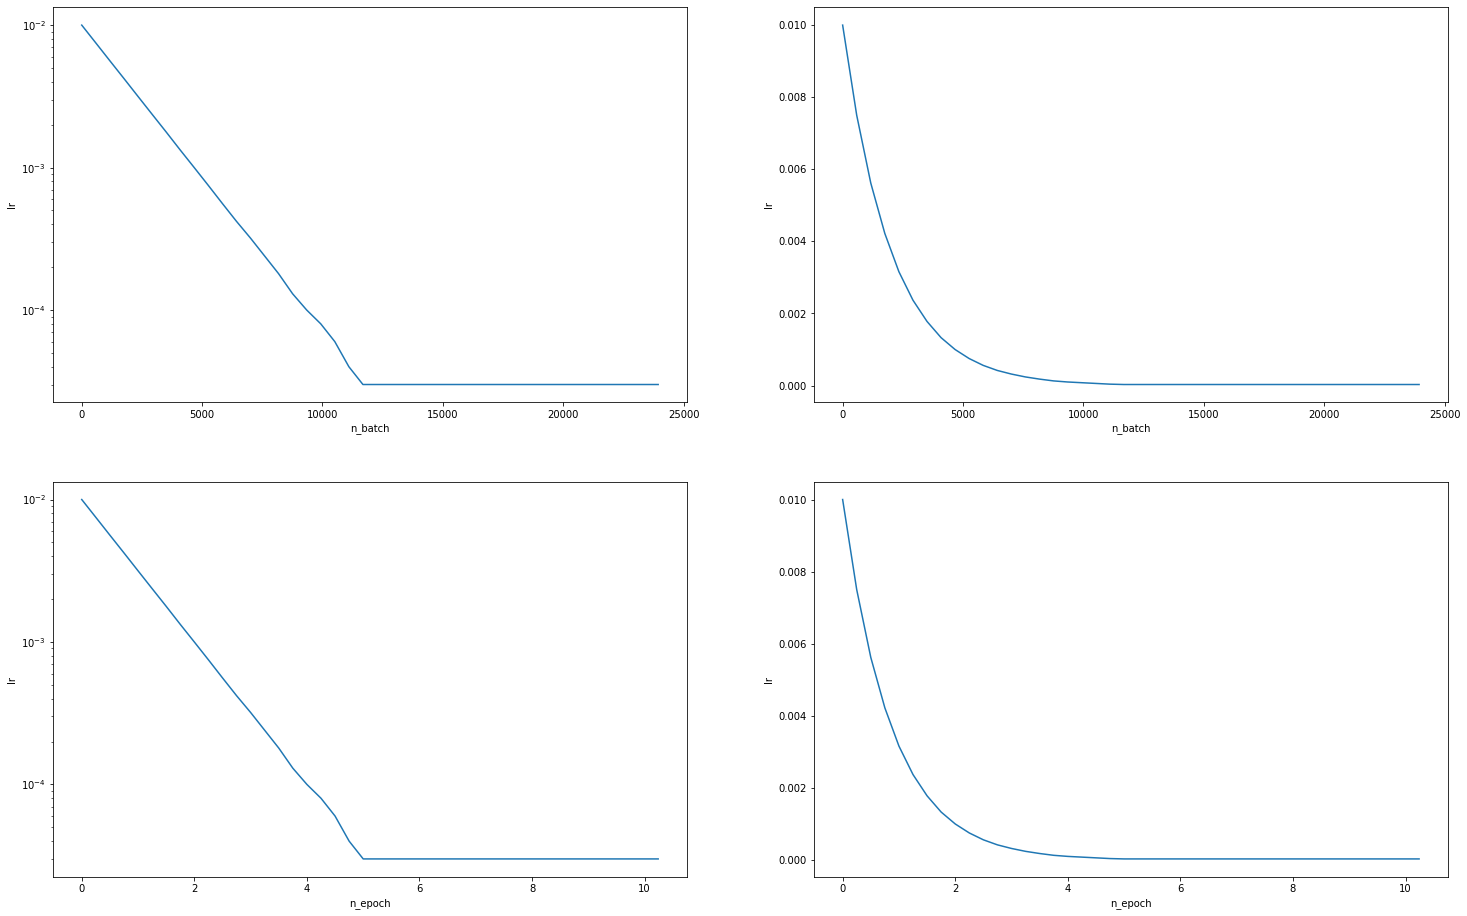

(0.0, 0.01)
(0.25, 0.0075)
(0.5, 0.00562)
(0.75, 0.00422)
(1.0, 0.00316)
(1.25, 0.00237)
(1.5, 0.00178)
(1.75, 0.00133)
(2.0, 0.001)
(2.25, 0.00075)
(2.5, 0.00056)
(2.75, 0.00042)
(3.0, 0.00032)
(3.25, 0.00024)
(3.5, 0.00018)
(3.75, 0.00013)
(4.0, 0.0001)
(4.25, 8e-05)
(4.5, 6e-05)
(4.75, 4e-05)
(5.0, 3e-05)
(5.25, 3e-05)
(5.5, 3e-05)
(5.75, 3e-05)
(5.99, 3e-05)
(6.24, 3e-05)
(6.49, 3e-05)
(6.74, 3e-05)
(6.99, 3e-05)
(7.24, 3e-05)
(7.49, 3e-05)
(7.74, 3e-05)
(7.99, 3e-05)
(8.24, 3e-05)
(8.49, 3e-05)
(8.74, 3e-05)
(8.99, 3e-05)
(9.24, 3e-05)
(9.49, 3e-05)
(9.74, 3e-05)
(9.99, 3e-05)
(10.24, 3e-05)
time: 743 ms


In [188]:
train_params.update({
    'base_model': 'resnet50',
    'epochs': 10,
    'lr': 1e-2,
    'lr_decay': 0.75,
#     'weight_decay': 0.01,
    'weight_decay': 0.0,
    'gpu': True,
})

n_train_batches = len(train_dataset) // train_params['batch_size']
patience = int(0.25 * n_train_batches)
min_lr = 3e-5
print(f"n_train_batches: {n_train_batches}, patience: {patience}")


lr = train_params['lr']
n_batch = 0
n_batch_lr_pairs = [(n_batch, lr)]
n_epoch_lr_pairs = [(n_batch / n_train_batches, lr)]
while n_batch < n_train_batches * train_params['epochs']:
    lr *= train_params['lr_decay']
    lr = max(lr, min_lr)
    n_batch += patience
    n_batch_lr_pairs.append((n_batch, round(lr, 5)))
    n_epoch_lr_pairs.append((round(n_batch / n_train_batches, 2), round(lr, 5)))

fig = plt.figure(figsize=(25, 2 * 8))

ax = fig.add_subplot(2, 2, 1)
ax.plot(*zip(*n_batch_lr_pairs))
ax.set_xlabel('n_batch')
ax.set_ylabel('lr')
ax.set_yscale("log")

ax = fig.add_subplot(2, 2, 2)
ax.plot(*zip(*n_batch_lr_pairs))
ax.set_xlabel('n_batch')
ax.set_ylabel('lr')

ax = fig.add_subplot(2, 2, 3)
ax.plot(*zip(*n_epoch_lr_pairs))
ax.set_xlabel('n_epoch')
ax.set_ylabel('lr')
ax.set_yscale("log")

ax = fig.add_subplot(2, 2, 4)
ax.plot(*zip(*n_epoch_lr_pairs))
ax.set_xlabel('n_epoch')
ax.set_ylabel('lr')

plt.show()
# fig.show()

print(*n_epoch_lr_pairs, sep='\n')

Создадим папку под эксперимент

In [189]:
exp_name = get_exp_name(train_params=train_params, name='baseline')
print(exp_name)
exp_dir = os.path.join(root_path, 'exp_dirs', exp_name)
os.makedirs(exp_dir)

May_04_2020_10:12:02__baseline_model=resnet50_bs=160_epochs=10_lr=0.01_lr_decay=0.75_w_decay=0.0
time: 13.2 ms


TensorBoard writer

In [190]:
writer = SummaryWriter(os.path.join(root_path, 'log_dir', exp_name))

time: 21.3 ms


Создадим модель

In [18]:
del model

NameError: name 'model' is not defined

time: 94.7 ms


In [191]:
device = torch.device("cuda: 0") if train_params['gpu'] else torch.device("cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 546 ms


In [192]:
len(train_dataset) // train_params['batch_size']

2338

time: 12.6 ms


In [193]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=train_params['lr'],
    weight_decay=train_params['weight_decay'],
    amsgrad=True,
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=train_params['lr_decay'], patience=patience,
    min_lr=min_lr,
)

# при малых ошибках это MSE, а при больших не хотим сильно реагировать на выбросы(MAE)
loss_fn = nn.SmoothL1Loss(reduction='none')  

time: 13.2 ms


Обучим и провалидируем модель

In [ ]:
best_val_loss = np.inf
for epoch in range(train_params['epochs']):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, 
                       device=device, epoch=epoch, writer=writer, scheduler=scheduler)
    writer.add_scalar('train_loss', train_loss, epoch)

    val_loss = validate(model, val_dataloader, loss_fn, device=device, epoch=epoch, writer=writer)
    writer.add_scalar('val_loss', val_loss, epoch)

    print(f"Epoch #{epoch:2}:\ttrain loss: {train_loss:5.2}\tval loss: {val_loss:5.2}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(exp_dir, "best_model.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

# Предсказание

### Подберем параметры и веса для костантной аугментации


0it [00:00, ?it/s]


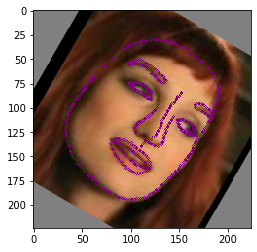

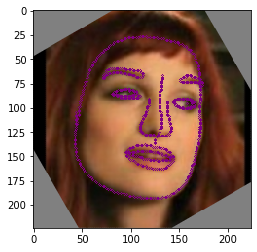

{'angle': tensor(-30., dtype=torch.float64),
 'scale': tensor(1., dtype=torch.float64),
 'x_center': tensor(112),
 'y_center': tensor(112),
 'x_offset': tensor(0),
 'y_offset': tensor(0)}

time: 421 ms


In [16]:
with_inv=True

# augmenter = RandomAugmentation(
#     augmenters_list=[
#         Augmenter(with_inv=with_inv),
#         BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv),
#         BlurAugmenter(max_kernel=5, with_inv=with_inv),
#         CropAugmenter(min_scale=0.8, with_inv=with_inv),
#         AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv),
#     ],
#     probs=[0.3, 0.2, 0.2, 0.15, 0.15],
# #     probs=[0.5, 0.5],
#     with_inv=with_inv,
# )
augmenter = AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv)
const_params_dict = dict(angle=-30., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0)
augmenter = constant_augmenter(augmenter, const_params_dict)

debug_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    augmenter,
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)), 
])

debug_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), debug_transforms, n_samples=10)
debug_dataloader = data.DataLoader(
    debug_dataset, batch_size=10, num_workers=0, #num_workers=4, 
    pin_memory=True, shuffle=False, drop_last=False,
)

batch = next(iter(debug_dataloader))
images = batch["image"]#.to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
landmarks = batch["landmarks"]


i =  np.random.choice(images.shape[0])
# image = images[i].numpy()
image = tensor_image2numpy(images[i])
landmark = landmarks[i].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

sample = get_i_from_dict(i, batch)
sample['image'] = tensor_image2numpy(sample['image'])
inv_sample = augmenter.inv(sample)


image = inv_sample['image']
landmark = inv_sample['landmarks'].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

del batch
del images
del landmarks
sample['params']

In [ ]:
with_inv = True
augmenter2params_weigth = {
    Augmenter(with_inv=with_inv): {
        'params': dict(),
        'weight': 0.3,
    },
    
    
    # повороты на +/- 10, 20 градусов
    AffineAugmenter(with_inv=with_inv): {
        'params': dict(angle=20., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0),
        'weight': 0.05,
    },    
    AffineAugmenter(with_inv=with_inv): {
        'params': dict(angle=10., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0),
        'weight': 0.1,
    },    
    AffineAugmenter(with_inv=with_inv): {
        'params': dict(angle=-10., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0),
        'weight': 0.1,
    },    
    AffineAugmenter(with_inv=with_inv): {
        'params': dict(angle=-20., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0),
        'weight': 0.05,
    },
    
    
    # обычно увеличение яркости и контраста улучшает изображение
    BrightnessContrastAugmenter(with_inv=with_inv): {
        'params': dict(brightness=0.1, contrast=1.2),
        'weight': 0.2,
    },
    
    # небольшая обрезка краев изображения(лицо становится крупней)
    CropAugmenter(with_inv=with_inv): {
        'params': dict(
            scale=0.9, 
            new_w=int(CROP_SIZE*0.9), new_h=int(CROP_SIZE*0.9), 
            x_offset=int(CROP_SIZE*0.05), y_offset=int(CROP_SIZE*0.05),
        ),
        'weight': 0.15,
    },
    # это скорее ухудшает, но мало ли)))
    BlurAugmenter(with_inv=with_inv): {
        'params': dict(kernel=3),
        'weight': 0.05,
    },
}

In [ ]:
transforms2weight = {}
sum_weight = 0
for augmenter, params_and_weigth in augmenter2params_weigth.items():
    augmenter = constant_augmenter(augmenter, params_and_weigth['params'])

    test_transforms = transforms.Compose([
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        augmenter,

        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225],
        ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
    ])
    
    transforms2weight[test_transforms] = params_and_weigth['weight']
    sum_weight += params_and_weigth['weight']
    
assert sum_weight == 1

Для обратного преобразовения предсказаний

In [ ]:
augmenter_classes = [Augmenter, AffineAugmenter, CropAugmenter, BrightnessContrastAugmenter, BlurAugmenter]
augmenter_name2class = {
    class_.name: class_
    for class_ in augmenter_classes
}

Загрузим тестовые данные

In [ ]:
# test_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'test'), train_transforms, split="test")
test_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'test'), val_transforms, split='test')

In [ ]:
def predict(model, dataset, device, transforms2weight):
    model.eval()
    not_restored_predictions = np.zeros((len(dataset), NUM_PTS, 2))
    predictions = np.zeros((len(dataset), NUM_PTS, 2))
    
    for t, weight in transforms2weight.items():
        dataset.transforms = t
        loader = data.DataLoader(
            dataset, batch_size=train_params['batch_size'], num_workers=0,#num_workers=4, 
            pin_memory=True, shuffle=False, drop_last=False,
        )
        choose_augmenter = True
        
        for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
            if choose_augmenter:
                augmenter = augmenter_name2class[batch['augmenter'][0]]()
                print(augmenter.name)
                choose_augmenter = False
            
            images = batch["image"].to(device)

            with torch.no_grad():
                pred_landmarks = model(images).cpu()
                
            # обратно конвертнуть
            batch["landmarks"] = pred_landmarks
            samples = batch2samples(batch=batch, size=pred_landmarks.shape[0])
            inv_samples = [augmenter.inv(sample) for sample in samples]
            inv_batch = loader.collate_fn(inv_samples)
            pred_landmarks = inv_batch["landmarks"]
            
            
            pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

            not_restored_predictions[i * loader.batch_size: (i + 1) * loader.batch_size] += pred_landmarks * weight
            
            fs = batch["scale_coef"].numpy()  # B
            margins_x = batch["crop_margin_x"].numpy()  # B
            margins_y = batch["crop_margin_y"].numpy()  # B
            prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
            predictions[i * loader.batch_size: (i + 1) * loader.batch_size] += prediction * weight

    return predictions, not_restored_predictions

In [ ]:
with open(os.path.join(exp_dir, "best_model.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

test_predictions, test_not_restored_predictions = predict(model, test_dataset, device, transforms2weight)
with open(os.path.join(exp_dir, "test_predictions.pkl"), "wb") as fp:
    pickle.dump({
            "image_names": test_dataset.image_names,
            "landmarks": test_predictions
        }, 
        fp,
    )

In [ ]:
create_submission(data_dir, test_predictions, os.path.join(exp_dir, "submit.csv"))

Посмотрим на итоговые предсказания

In [ ]:
test_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
#     augmenter,

    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
])

test_dataset.transforms = test_transforms

In [ ]:
n_images = 8
idxs = np.random.choice(len(test_dataset), size=n_images, replace=False)

images = val_dataloader.collate_fn([test_dataset[idx] for idx in idxs])["image"]

model.eval()
with torch.no_grad():
    images = images.to(device)
    simple_pred_landmarks = model(images).cpu()

images = images.cpu()
fig = figure_landmark_examples(images=images, landmarks=test_not_restored_predictions[idxs], landmarks2=simple_pred_landmarks)
plt.show()

Оценим, какое примерно, отличие в итоговом MSE даст такое "ансамблирование" аугментациями

In [ ]:
np.sum(
    (test_not_restored_predictions[idxs].reshape(-1) - np.array(simple_pred_landmarks).reshape(-1))**2
) / simple_pred_landmarks.shape[0] / NUM_PTS